In [11]:
%%capture
!pip install skyfield

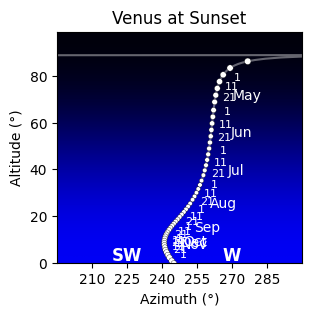

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skyfield import almanac
from skyfield.api import load, wgs84
from skyfield.magnitudelib import planetary_magnitude

MONTH_NAMES = '0 Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()

# Figure out the times of sunset over our range of dates.

eph = load('de421.bsp')
earth, sun, venus = eph['earth'], eph['sun'], eph['mars']
observer = wgs84.latlon(20.994757490485334, 105.8677118221801)

ts = load.timescale()
start, end = ts.utc(2025, 3, 1), ts.utc(2026, 3, 1)

f = almanac.sunrise_sunset(eph, observer)
t, y = almanac.find_discrete(start, end, f)
sunsets = (y == 0)
t = t[sunsets]

# For each moment of sunset, ask Skyfield for the month number, the day
# number, and for Venus’s altitude, azimuth, and magnitude.

year, month, day, hour, minute, second = t.utc
month = month.astype(int)
day = day.astype(int)

apparent = (earth + observer).at(t).observe(venus).apparent()
alt, az, distance = apparent.altaz()
x, y = az.degrees, alt.degrees
m = planetary_magnitude(apparent)

# Convert magnitude to marker size, remembering that smaller magnitude
# numbers mean a brighter Venus (and thus a larger marker).

maxmag = max(m)
minmag = min(m)
size = 40 - 30 * (m - minmag) / (maxmag - minmag)

# Start with a smooth curve tracing Venus's motion.

fig, ax = plt.subplots(figsize=[9, 3])
ax.plot(x, y, c='#fff6', zorder=1)

# Next, put a circle representing Venus on the 1st of the month and on
# every fifth day after that.  (Except for the 30th, which would sit too
# close to the 1st of the following month.)

fives = (day % 5 == 1) & (day < 30)
ax.scatter(x[fives], y[fives], size[fives], 'white',
           edgecolor='black', linewidth=0.25, zorder=2)

# Put day and month labels off to the sides of the curve.

offset_x, offset_y = 10, 8

for i in np.flatnonzero(fives):
    if i == 0:
        continue  # We can’t compute dx/dy with no previous point.

    # Build a unit vector pointing in the direction Venus is traveling.

    day_i = day[i]
    xi = x[i]
    yi = y[i]
    dx = xi - x[i-1]
    dy = yi - y[i-1]
    length = np.sqrt(dx*dx + dy*dy)
    dx /= length
    dy /= length

    # Offset the text at a right angle to the direction of travel.

    side = 'right' if (year[i], month[i]) < (2021, 10) else 'left'
    if side == 'left':
        xytext = - offset_x*dy, offset_y*dx
    else:
        xytext = offset_x*dy, - offset_y*dx

    # Label the dates 1, 11, and 21.

    if day_i in (1, 11, 21):
        ax.annotate(day_i, (xi, yi), c='white', ha='center', va='center',
                    textcoords='offset points', xytext=xytext, size=8)

    # On the 15th of each month, put the month name.

    if day_i == 16:
        name = MONTH_NAMES[month[i]]
        ax.annotate(name, (xi, yi), c='white', ha='center', va='center',
                    textcoords='offset points', xytext=2.2 * np.array(xytext))

# Finally, some decorations.

points = 'N NE E SE S SW W NW'.split()
for i, name in enumerate(points):
    xy = 45 * i, 1
    ax.annotate(name, xy, c='white', ha='center', size=12, weight='bold')

ax.set(
    aspect=1.0,
    title='Venus at Sunset',
    xlabel='Azimuth (°)',
    ylabel='Altitude (°)',
    xlim=(195, 300),
    ylim=(0, max(y) + 10.0),
    xticks=np.arange(210, 300, 15),
)

sky = LinearSegmentedColormap.from_list('sky', ['black', 'blue'])
extent = ax.get_xlim() + ax.get_ylim()
ax.imshow([[0,0], [1,1]], cmap=sky, interpolation='bicubic', extent=extent)

fig.savefig('venus_evening_chart.png', dpi=300)